<a href="https://colab.research.google.com/github/gabrielecerizza/amd_project/blob/master/similar_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload kaggle.json using the cell below

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip -d dataset
!rm ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip

In [ ]:
!pip install transformers

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import csv
import datetime
import hashlib
import os
import pathlib
import pickle
import random
import re
import string
import timeit
import unicodedata
from collections import defaultdict
from itertools import combinations
from typing import (
    Callable, Dict, 
    List, Optional, 
    Set, Tuple
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
from nltk.corpus import stopwords
from scipy.optimize import fsolve
from scipy.stats import kendalltau, spearmanr
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

In [3]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
stops = set(stopwords.words('english'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Implementation

## Hash utils

In [4]:
def is_prime(n: int) -> bool:
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n))+1):
        if (n % i) == 0:
            return False
    return True

def find_closest_prime(n: int) -> int:
    """Finds the closest prime number higher than input."""
    while True:
        if is_prime(n):
            return n
        n += 1

def get_variable_length_hash(
    n_bits: int
) -> Callable[[str], int]:
    """Generates a hash function that takes a string
    as input and has 2 ** n_bits integer buckets.
    """
    def inner_f(s: str) -> int:
        binary_str = bin(
            int.from_bytes(
                hashlib.sha256(s.encode()).digest(), 
                'little'
            )
        )[-n_bits:]
        return int(binary_str, 2)
    return inner_f

class HashGenerator:
    """Generator of hash functions of the form:
            
            h(x) = (ax + b) mod c
    
    where x is a row number, a and b are random numbers
    smaller than the maximum row number and c is a prime
    number higher than the maximum row number.

    This approach to hash function generation was suggested
    in [1].

    Parameters
    ----------
    num_rows : int
        Maximum number of rows of the characteristic matrix.

    seed : int
        The seed for the random generation.

    References
    ----------
        [1] http://ethen8181.github.io/machine-learning/clustering_old/text_similarity/text_similarity.html

    """
    def __init__(
        self, 
        num_rows: int,
        seed: int = 34 
    ) -> None:
        self.num_rows = num_rows
        self.prime = find_closest_prime(num_rows)
        random.seed(seed)

    def get_num_rows(self) -> int:
        return self.num_rows

    def next(self) -> Callable[[np.uint32], np.uint32]:
        """Returns a hash function that takes a row number 
        as input and returns another row number as output.
        """
        a = self._generate_coeff(self.num_rows)
        b = self._generate_coeff(self.num_rows)
        return lambda row: np.uint32((a * row + b) % self.prime)

    def _generate_coeff(
        self, 
        max_val: int
    ) -> int:
        return random.randint(1, max_val)

## Preprocessing utils

In [5]:
def normalize_white_space(doc: str) -> str:
    return " ".join(doc.split())

def remove_https(doc: str) -> str:
    return re.sub(r'https?://[^ ]+', '', doc)

def replace_chars(doc: str) -> str:
    return doc.replace('&amp;', ' and ')

def remove_non_ascii(doc: str) -> str:
    """Removes non ascii and non printable characters.
    We keep cyrillic characters due to the nature
    of the dataset.
    """
    cyr_chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"

    res = ""
    for c in doc:
        if (c.isascii() and c.isprintable()) \
            or (c in cyr_chars) or c.isspace():
            res += c
    return res

def strip_accents(doc: str) -> str:
    """Replaces words with accent with their 
    counterpart without accent. This also deals with 
    special characters such as 𝕒, 𝕕, 𝕖, 𝙖, 𝙘, 𝙙. 
    """
    return unicodedata.normalize('NFKD', doc)

def strip_punctuation(doc: str) -> str:
    return re.sub('[' + re.escape(string.punctuation) + ']+', '', doc)
    
def get_lemmatizer( 
    nlp: spacy.pipeline, 
    allow_stop_words: bool = False,
    allow_punct: bool = False,
    allow_numbers: bool = False
) -> Callable[[str], str]:
    """Generates a function that takes a string as
    input and returns the string sequence of lemmas
    in the input string. Optionally, the generated
    function removes stop words, punctuation and
    numbers.

    Note that numbers are tokens identified as such.
    For instance, '62,000' is a number, but 'T-72' is
    not.

    Parameters
    ----------
    nlp : spacy.pipeline
        Spacy object that carries out the lemmatization.
    
    allow_stop_words : bool
        Boolean value to filter or allow stop words.

    allow_punct : bool
        Boolean value to filter or allow punctuation.
    
    allow_numbers : bool
        Boolean value to filter or allow numbers.

    Returns
    -------
    The generated function. 
    """
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token.lemma_
                for token in nlp(doc)
                if (not token.is_stop or allow_stop_words) \
                    and (not token.is_punct or allow_punct) \
                    and (token.pos_ != 'NUM' or allow_numbers) \
                    and (not token.pos_ == 'X')
            ]
        )
    return inner_f

def remove_handles(doc: str) -> str:
    return re.sub(r'@\w+', '', doc)

def remove_short(n: int) -> Callable[[str], str]:
    def inner_f(doc: str) -> str:
        if len(doc) < n:
            return ''
        else:
            return doc

    return inner_f

def get_stopwords_remover(
    stops: list
) -> Callable[[str], str]:
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token for token in doc.split()
                if token not in stops
            ]
        )
    return inner_f

## Model

In [6]:
def jaccard_similarity(
    x: np.ndarray, 
    y: np.ndarray
) -> float:
    numerator = len(set(x).intersection(set(y)))
    denominator = len(set(x).union(set(y)))
    return numerator / denominator

class LSHModel:
    """Implementation of LSH model that finds similar pairs
    of documents encoded as k-gram shingles.

    Parameters
    ----------
    k : int
        Number of characters in each k-gram.

    threshold : float
        The similarity value required to consider a
        pair as similar.

    num_hashes : int
        Number of hash functions used to generate the
        signature matrix.

    shingle_hash_bits : int
        Determines the number of buckets of the hash
        function that maps each shingle to an integer.

    track_shingles : bool
        Flag to keep track of the number of different
        shingles found in the corpus, as well as the
        number of different characters in the shingles.

    checkpoint_path : Optional[str]
        Path to save and load the state of the model.
    """
    def __init__(
        self,
        k: int,
        threshold: float,
        num_hashes: int,
        shingle_hash_bits: int,
        track_shingles: bool = False,
        checkpoint_path: Optional[str] = None
    ) -> None:
        self.k = k
        self.threshold = threshold
        self.num_hashes = num_hashes
        self.shingle_set = set()
        self.char_set = set()
        self.shingle_hash_bits = shingle_hash_bits
        self.shingle_hash = get_variable_length_hash(
            shingle_hash_bits
        )
        self.num_shingles = 2 ** shingle_hash_bits
        self.track_shingles = track_shingles
        self.checkpoint_path = checkpoint_path
        self.num_docs = 0
        self.docs_dict = dict()
        self.signature = None
        self.candidate_pairs = set()
        self.fp_pairs = set()
        self.similar_pairs = set()
        self.b = -1
        self.r = -1
        self.sig_idx = -1

    def load_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', 'docs_dict'),
                (f'{self.checkpoint_path}/shingle_set.npy', 'shingle_set'),
                (f'{self.checkpoint_path}/char_set.npy', 'char_set'),
                (f'{self.checkpoint_path}/signature.npy', 'signature'),
                (f'{self.checkpoint_path}/sig_idx.npy', 'sig_idx'),
                (f'{self.checkpoint_path}/candidate_pairs.npy', 'candidate_pairs'),
                (f'{self.checkpoint_path}/fp_pairs.npy', 'fp_pairs'),
                (f'{self.checkpoint_path}/similar_pairs.npy', 'similar_pairs')
            ]

            for file_path, attr in tup_ls:
                if os.path.isfile(file_path):
                    if attr in ['signature']:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True)
                        )
                    else:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True).item()
                        )
                        
    def save_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            os.makedirs(self.checkpoint_path, exist_ok=True)

            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', self.docs_dict),
                (f'{self.checkpoint_path}/shingle_set.npy', self.shingle_set),
                (f'{self.checkpoint_path}/char_set.npy', self.char_set),
                (f'{self.checkpoint_path}/signature.npy', self.signature),
                (f'{self.checkpoint_path}/sig_idx.npy', self.sig_idx),
                (f'{self.checkpoint_path}/candidate_pairs.npy', self.candidate_pairs),
                (f'{self.checkpoint_path}/fp_pairs.npy', self.fp_pairs),
                (f'{self.checkpoint_path}/similar_pairs.npy', self.similar_pairs)
            ]

            for file_path, val in tup_ls:
                np.save(file_path, val)

    def add_document(
        self, 
        doc: str,
        preprocessing_pipeline: Optional[List[Callable[[str], str]]] = None
    ) -> None:
        """Creates shingles from the document given in input and
        adds those shingles to the model. Optionally, the document
        is preprocessed with a number of functions given in a 
        pipeline.

        Parameters
        ----------
        doc : str
            String document to be processed.

        preprocessing_pipeline : Optional[list[Callable[[str], str]]]
            List of functions that take a string and return a string.
            This is used to filter stop words, apply lemmatization, etc.
        """
        if preprocessing_pipeline is not None:
            for f in preprocessing_pipeline:
                doc = f(doc)
        
        shingles = self._create_shingles(
            doc, 
            self.k,
            self.track_shingles,
            self.shingle_hash
        )

        self.docs_dict[self.num_docs] = shingles
        self.num_docs += 1

    def get_similar_pairs(
        self,
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> Set[Tuple[Tuple[int, int], float]]:
        """Returns the pairs having an approximated similarity 
        higher than a fixed threshold. The pairs are provided as 
        a set of tuples containing the indices of the documents and
        their similarity value. 
        
        The approximated similarity measure is the Jaccard
        similarity.

        This function also saves the false positive pairs identified
        after double-checking the signature matrix.

        Parameters
        ----------
        checkpoint_path : Optional[str]
            Path to save and load the state of the model. This is used
            when building the signature matrix.

        checkpoint_freq : int
            Frequency with which the state of the model is saved.
        
        Returns
        -------
        The set of pairs approximately similar, alongside their 
        similarity value.
        """
        hg = HashGenerator(self.num_shingles)
        hash_functions = [
            hg.next()
            for _ in range(self.num_hashes)
        ]
        self.signature = self._build_signature(
            self.docs_dict,
            self.num_shingles,
            hash_functions,
            checkpoint_path,
            checkpoint_freq
        )
        self.b, self.r = self._find_lsh_params(
            self.threshold,
            self.num_hashes
        )
        self.candidate_pairs = self._lsh(
            self.signature,
            self.b
        )
        self.similar_pairs, self.fp_pairs = \
            self._check_threshold_on_signature(
                self.candidate_pairs,
                self.signature,
                self.threshold
            )
        return self.similar_pairs

    def _create_shingles(
        self,
        doc: str, 
        k: int,
        track_shingles: bool, 
        hash_f: Callable[[str], int]
    ) -> np.ndarray:
        res = []

        for i in range(len(doc[:-k+1])):
            shingle = doc[i:i+k]
            if track_shingles:
                self.shingle_set.add(shingle)
                self.char_set = self.char_set.union(
                    set(shingle)
                ) 
            res.append(hash_f(shingle))

        return np.unique(res).astype(np.uint32)

    def _build_signature(
        self,
        docs_dict: Dict[int, np.ndarray],
        num_rows: int, 
        hash_functions: List[Callable[[np.uint32], np.uint32]],
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> np.ndarray:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is not None:
            os.makedirs(self.checkpoint_path, exist_ok=True)
        
        sig_path = f'{self.checkpoint_path}/temp_signature.npy'
        sig_idx_path = f'{self.checkpoint_path}/temp_sig_idx.npy'
        
        if self.checkpoint_path is not None and \
            os.path.isfile(sig_path) and \
            os.path.isfile(sig_idx_path):
                signature = np.load(sig_path, allow_pickle=True)
                self.sig_idx = np.load(
                    sig_idx_path, 
                    allow_pickle=True
                ).item()
                print(f"Loaded signature from row {self.sig_idx}")
        else:
            signature = np.full(
                (len(hash_functions), len(docs_dict)), 
                fill_value=np.inf
            )
            self.sig_idx = -1

        for r in tqdm(
            range(0, num_rows),
            total=num_rows,
            desc='[Signature matrix] row number',
            leave=False
        ):
            if r < self.sig_idx:
                continue

            hash_values = [
                f(r)
                for f in hash_functions
            ]
            for c, shingles in enumerate(docs_dict.values()):
                if r in shingles:
                    for i, hash_val in enumerate(hash_values):
                        if hash_val < signature[i,c]:
                            signature[i,c] = hash_val

            self.sig_idx = r
            if (self.sig_idx % checkpoint_freq == 0) and \
                self.checkpoint_path is not None:
                np.save(sig_path, signature)
                np.save(sig_idx_path, self.sig_idx)

        if self.checkpoint_path is not None:
            np.save(sig_path, signature)
            np.save(sig_idx_path, self.sig_idx)
        
        return signature.astype(np.uint32)

    def _find_lsh_params(self, t: int, n: int) -> Tuple[int]:
        """Note that a lower b means that two items must match 
        a higher number of rows. By taking the floor of b, we 
        favor more similar pairs.

        Sympy did not always find a solution.
        """
        def equations(vars):
            b, r = vars
            eq1 = t - (1 / b) ** (1 / r)
            eq2 = n - b * r
            return [eq1, eq2]

        b, r =  fsolve(equations, (1, 1))
        b = np.floor(b)
        r = n // b
        return int(b), int(r)

    def _lsh(
        self, 
        signature: np.ndarray, 
        b: int
    ) -> Set[Tuple[int, int]]:
        candidate_pairs = set()
        
        bands = np.array_split(signature, b)

        for band in tqdm(
            bands,
            total=len(bands),
            desc='[LSH] band number',
            leave=False
        ):
            # column tuple -> list of column indices having that tuple
            same_columns = defaultdict(list) 
            
            for c in range(band.shape[1]):
                column = band[:,c]
                str_column = ''.join([str(num) for num in column])
                same_columns[hash(str_column)].append(c)

            for k in list(same_columns.keys()):
                if len(same_columns[k]) < 2:
                    del same_columns[k]

            for values in same_columns.values():
                indices = range(len(values))
                for i in indices:
                    for j in range(i+1, len(values)):
                        candidate_pairs.add((values[i], values[j]))

        return candidate_pairs

    def _check_threshold_on_signature(
        self, 
        candidate_pairs: List[Tuple[int, int]], 
        signature: np.ndarray, 
        t: float
    ) -> Tuple[Set[Tuple[Tuple[int, int], float]]]:
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in tqdm(
            candidate_pairs,
            total=len(candidate_pairs),
            desc='[Threshold check] pair number',
            leave=False
        ):
            x_col = signature[:,x]
            y_col = signature[:,y]
            similarity = sum(x_col == y_col) / signature.shape[0]
            tup = ((x, y), similarity)
            if similarity >= t:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def check_positives(self) -> Tuple[Set[Tuple[Tuple[int, int], float]]]:
        """Returns two sets of pairs. The first is the set
        of true positive pairs obtained after checking the
        pairs returned by the LSH procedure against the actual 
        Jaccard similarity computed from the characteristic matrix.
        The second is the set of false positive pairs identified
        after the double-check against the characteristic matrix.
        """
        true_positive_pairs = set()
        false_positive_pairs = set()

        for ((x, y), _) in self.similar_pairs:
            sim = jaccard_similarity(
                self.docs_dict[x], 
                self.docs_dict[y]
            )
            tup = ((x, y), sim)
            if sim >= self.threshold:
                true_positive_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return true_positive_pairs, false_positive_pairs

    def check_negatives(self) -> Tuple[Set[Tuple[Tuple[int, int], float]]]:
        """Returns two sets of pairs. The first is the set
        of true negative pairs obtained after checking the
        pairs returned by the LSH procedure against the actual 
        Jaccard similarity computed from the characteristic matrix.
        The second is the set of false negative pairs identified
        after computing the Jaccard similarity on the characteristic 
        matrix.
        """
        true_negatives = set()
        false_negatives = set()

        candidates = [pair[0] for pair in self.similar_pairs]

        indices = range(len(self.docs_dict))
        for i in indices:
            for j in range(i+1, len(self.docs_dict)):
                sim = jaccard_similarity(self.docs_dict[i], self.docs_dict[j])
                neg = sim < self.threshold
                tup = ((i, j), sim)
                if ((i, j) not in candidates) and neg:
                    true_negatives.add(tup)
                elif ((i, j) not in candidates) and (not neg):
                    false_negatives.add(tup)

        return true_negatives, false_negatives

    def get_shingle_set(self) -> Set[int]:
        return self.shingle_set

    def get_char_set(self) -> Set[str]:
        return self.char_set

    def get_docs_dict(self) -> Dict[int, np.ndarray]:
        return self.docs_dict

## General utils

In [7]:
def mean_absolute_error(
    x: list, 
    y: list
) -> float:
    return sum(
        [np.abs(val2 - val1) for val1, val2 in zip(x, y)]
    ) / (len(x) or 1e-10) # to avoid division by zero

def evaluate_on_cm(
    sig_dict: Dict[Tuple[int, int], float], 
    cm_tp_dict: Dict[Tuple[int, int], float],
    cm_fp_dict: Dict[Tuple[int, int], float],
    cm_tn_dict: Optional[Dict[Tuple[int, int], float]] = None,
    cm_fn_dict: Optional[Dict[Tuple[int, int], float]] = None
) -> Dict[str, Tuple[int, float]]:
    """Evaluates the model performance by computing
    precision, accuracy, F1 score and the mean absolute error (MAE) 
    against the characteristic matrix. The MAE is
    computed only on true positives and false positives,
    since the LSH algorithm does not compute the similarity
    for all the possible pairs.

    Parameters
    ----------
    sig_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained as
        estimation from the signature matrix.

    cm_tp_dict : dict[tuple[int, int], float]
        Dictionary that maps each true positive pair to 
        the corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.

    cm_fp_dict : dict[tuple[int, int], float]
        Dictionary that maps each false positive pair to 
        the corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    cm_tn_dict : Optional[dict[tuple[int, int], float]]
        Dictionary that maps each true negative pair to 
        the corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    cm_fn_dict : Optional[dict[tuple[int, int], float]]
        Dictionary that maps each false negative pair to 
        the corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    Returns
    -------
    Dictionary containing precision and the MAE. If negatives
    are provided, the dictionary will contain also recall, F1 score
    and accuracy.
    """
    res_dict = dict()

    sig_values = []
    cm_values = []

    for pair in cm_tp_dict:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_tp_dict[pair])
    for pair in cm_fp_dict:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_fp_dict[pair])

    res_dict['precision'] = len(cm_tp_dict) / (len(sig_dict) or 1e-10)
    res_dict['mae'] = mean_absolute_error(sig_values, cm_values) 

    if cm_tn_dict is not None and cm_fn_dict is not None:
        res_dict['recall'] = len(cm_tp_dict) \
            / (len(cm_tp_dict) + len(cm_fn_dict))
        res_dict['accuracy'] = (len(cm_tp_dict) + len(cm_tn_dict)) \
            / (len(sig_dict) + len(cm_tn_dict) + len(cm_fn_dict))
        res_dict['f1-score'] = len(cm_tp_dict) \
            / (len(cm_tp_dict) + 0.5*(len(cm_fp_dict) + len(cm_fn_dict)))

    return res_dict     

def train_model(
    model: LSHModel, 
    data_path: str, 
    num_docs: int,
    num_blocks: int = 18,
    verbose: bool = False,
    filtering_pipeline: Optional[List[Callable[[str], str]]] = None, 
    preprocessing_pipeline: Optional[List[Callable[[str], str]]] = None  
) -> LSHModel:
    """Trains the model on a given number of documents
    taken from a provided dataset. Training here means
    adding the shingles of the documents to the model.

    Parameters
    ----------
    model : LSHModel
        The model to be trained.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_docs : int
        The number of documents on which the model
        will be trained.

    num_blocks : int
        Number of files to read in chunks.

    verbose : bool
        Flag that determines whether to print 
        information about the processing.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model and will be used to 
        determine duplicates to drop.

    preprocessing_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used to preprocess documents being added to 
        the model.
    
    Returns
    -------
    The trained model.
    """
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    files = np.array(sorted(files))
    duplicates = 0
    count = num_docs

    with tqdm(
        total=num_docs,
        desc='Adding documents to model',
        leave=False
    ) as pbar:

        files_blocks = np.array_split(files, num_blocks)

        for file_block in files_blocks:

            dfs = []

            for file in file_block:
                if count == 0:
                    break

                if verbose:
                    print(f'Reading file {file}')
                file_df = pd.read_csv(
                    file, 
                    compression='gzip', 
                    index_col=0,
                    encoding='utf-8', 
                    quoting=csv.QUOTE_ALL,
                    low_memory=False
                )
                file_df = file_df[file_df['language'] == 'en']
                dfs.append(file_df)

            df = pd.concat(dfs).reset_index()

            if filtering_pipeline is not None:
                for filter_f in filtering_pipeline:
                    df['text'] = df['text'].apply(filter_f)

            df_unique = df.drop_duplicates(subset=['text'])
            df_unique = df_unique[df_unique['text'] != '']
            duplicates += len(df) - len(df_unique)

            for index, row in tqdm(
                df_unique.iterrows(),
                total=len(df_unique),
                desc='Reading file',
                leave=False
            ):
                text = row['text']
                model.add_document(
                    text,
                    preprocessing_pipeline
                )
                
                count -= 1
                pbar.update(1)
                if count == 0:
                    if verbose:       
                        print(f'Filtered {duplicates} rows in files, kept {len(df_unique)}')
                    return model

def get_text(
    idx_ls: List[int], 
    data_path: str,
    num_blocks: int = 18,
    filtering_pipeline: Optional[List[Callable[[str], str]]] = None,
    add_info: bool = True
) -> List[Tuple[int, str]]:
    """Returns a list containing the original texts
    from the dataset (before the preprocessing) alongside
    their indices.

    Parameters
    ----------
    idx_ls : list[int]
        The list of the indices of the documents to 
        be retrieved.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_blocks : int
        Number of files to read in chunks.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model and will be used to 
        determine duplicates to drop.
    
    add_info : bool
        Add all info from the record of each text.

    Returns
    -------
    Tuples containing the indices of the documents and their
    original text. Optionally, also the information from the 
    records may be added.
    """
    max_idx = max(idx_ls)
    result = []
    
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)
    
    files = np.array(sorted(files))
    count = 0

    files_blocks = np.array_split(files, num_blocks)

    for file_block in tqdm(
        files_blocks,
        total=len(files_blocks),
        desc='File block',
        leave=False
    ):

        dfs = []

        for file in file_block:
            print(f'Reading file {file}')

            file_df = pd.read_csv(
                file, 
                compression='gzip', 
                index_col=0,
                encoding='utf-8', 
                quoting=csv.QUOTE_ALL,
                low_memory=False
            )
            file_df = file_df[file_df['language'] == 'en']
            dfs.append(file_df)

        df = pd.concat(dfs).reset_index()
        df_to_filter = df.copy()

        if filtering_pipeline is not None:
            for filter_f in filtering_pipeline:
                df_to_filter['text'] = df_to_filter['text'].apply(filter_f)

        df_unique = df_to_filter.drop_duplicates(subset=['text'])
        df_unique = df_unique[df_unique['text'] != '']
        df_filtered = df.iloc[df_unique.index]

        for index, row in tqdm(
            df_filtered.iterrows(),
            total=len(df_filtered),
            desc='Reading file',
            leave=False
        ):
            if count in idx_ls:
                result.append(
                    (count, row['text'], row) if add_info
                    else (count, row['text'])
                )
            if count == max_idx:
                return result
            count += 1

def mean_pooling(
    model_output: torch.Tensor, 
    attn_mask: torch.Tensor
) -> torch.Tensor:
    """Returns the mean of the embeddings taken from 
    the last layer of the model, in order to give 
    a single embedding for each document. The mean
    is weighted with the attention mask, so that 
    the padding and control tokens added by the model
    are not considered in the mean.

    Parameters
    ----------
    model_output : torch.Tensor
        Embeddings for all the documents.

    attn_mask : torch.Tensor
        The attention mask of the model for all the
        documents.
    
    Returns
    -------
    The weighted mean embedding for each document. 
    """
    token_embeddings = model_output['last_hidden_state']

    # attn_mask shape: [13, 512] -> [13, 512, 768]
    expanded_attn_mask = attn_mask.unsqueeze(-1).expand_as(token_embeddings)

    # * or torch.mul: out_i = input_i x other_i 
    # might use torch.clamp to avoid dividing by 0
    return torch.sum(
        token_embeddings * expanded_attn_mask, 1
    ) / expanded_attn_mask.sum(1)

def torch_cosine_similarity(x, y):
    return torch.matmul(
        F.normalize(x, dim=-1), 
        F.normalize(y, dim=-1)
    )

def compare_similarity(
    model: AutoModel,
    tokenizer: AutoTokenizer,
    data_path: str,
    model_preprocessing: List[Callable[[str], str]],
    filtering_pipeline: List[Callable[[str], str]],
    similar_pairs: List[Tuple[Tuple[int, int], float]],
    device: str,
    doc_sims: bool = False
):
    """Takes similar pairs with their similarity value, 
    creates embeddings for the documents of these pairs,
    computes the cosine similarity between the embeddings
    and returns Kendall's Tau and Spearman's rank order
    correlations between the provided similarity values
    and the similarity values obtained from the embeddings.
    It also computes the rank order correlation for the pairs
    involving each specific document.

    Parameters
    ----------
    model : AutoModel
        Model from the transformers library.
    
    tokenizer : AutoTokenizer
        Tokenizer from the transformers library.
    
    data_path : str
        The path where the files of the dataset are
        stored.
    
    model_preprocessing : list[Callable[[str], str]]
        List of functions that take a string and return a string.
        This is used before feeding the documents to the model.
    
    filtering_pipeline : list[Callable[[str], str]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, when
        retrieving the documents, in order to drop duplicates.
    
    similar_pairs : list[tuple[tuple[int, int], float]]
        List of tuples ((pair_idx, pair_idx), value).
    
    device : str
        String that determines what device to use with torch
        (cuda or cpu).

    doc_sims : bool
        Flag to trigger the computation of the similarities
        within each list of pairs containing a given document.

    Returns
    -------
    A dictionary containing Kendall's Tau and Spearman's rank order correlations. 
    """

    result = dict()

    idx_ls = np.unique(
        np.array(
            [
                list(pair)
                for pair, _ in similar_pairs
            ] 
        ).flatten()
    )
    text_dict = dict(
        get_text(
            idx_ls, 
            data_path, 
            filtering_pipeline=filtering_pipeline,
            add_info=False
        )
    )

    preprocessed_texts = []
    for text in text_dict.values():
        for f in model_preprocessing:
            text = f(text)
        preprocessed_texts.append(text)

    encoded_input = tokenizer(
        preprocessed_texts,
        max_length=100, 
        padding='max_length', 
        truncation=True, 
        return_tensors='pt'
    ).to(device)

    embeddings_dict = dict()

    with torch.no_grad():
        input_ids = encoded_input['input_ids']
        attention_mask = encoded_input['attention_mask']
        dict_keys = torch.Tensor(list(text_dict.keys()))
        ids_ls = input_ids.split(100)
        attn_ls = attention_mask.split(100)
        keys_ls = dict_keys.split(100)
        for ids, attn, keys in tqdm(
            zip(ids_ls, attn_ls, keys_ls),
            total=len(ids_ls),
            desc='Computing embeddings',
            leave=False
        ):
            model_output = model(
                input_ids=ids,
                attention_mask=attn
            )

            embeddings = mean_pooling(
                model_output, 
                attn
            )

            for key, val in zip(keys, embeddings):
                embeddings_dict[int(key)] = val

    tot_lsh_sims = []
    tot_model_sims = []

    for ((x_idx, y_idx), lsh_sim) in tqdm(
        similar_pairs,
        total=len(similar_pairs),
        desc='Computing total similarity',
        leave=False
    ):
        tot_lsh_sims.append(lsh_sim)
        tot_model_sims.append(
            torch_cosine_similarity(
                embeddings_dict[x_idx],
                embeddings_dict[y_idx],
            ).cpu().numpy()
        )

    result['tot_kendall'] = kendalltau(
        tot_lsh_sims, 
        tot_model_sims
    )
    result['tot_spearman'] = spearmanr(
        tot_lsh_sims, 
        tot_model_sims
    )

    if doc_sims:
        result['doc_sims'] = []
        for doc_idx in tqdm(
            idx_ls,
            total=len(idx_ls),
            desc='Computing similarity for each doc',
            leave=False
        ):
            lsh_sims = []
            model_sims = []

            doc_pairs = [
                pair for pair in similar_pairs
                if doc_idx in pair[0]
            ]

            for ((x_idx, y_idx), lsh_sim) in doc_pairs:
                lsh_sims.append(lsh_sim)
                model_sims.append(
                    torch_cosine_similarity(
                        embeddings_dict[x_idx],
                        embeddings_dict[y_idx],
                    ).cpu().numpy()
                )

            result['doc_sims'].append(
                (
                    doc_idx,
                    kendalltau(lsh_sims, model_sims),
                    spearmanr(lsh_sims, model_sims),
                    lsh_sims,
                    model_sims
                )
            )

    return result

# Experiments

In [8]:
if os.path.isdir(r'e:\datasets\ukraine'):
    DATA_PATH = r'e:\datasets\ukraine'
else:
    DATA_PATH = os.path.join(os.getcwd(), 'dataset')

os.makedirs('img', exist_ok=True)

In [9]:
filtering_pipeline = [
    remove_https,
    remove_handles,
    strip_accents,
    replace_chars,
    str.lower,
    remove_non_ascii,
    strip_punctuation,
    get_stopwords_remover(stops),
    normalize_white_space,
    remove_short(100)
]

preprocessing_pipeline = [
    get_lemmatizer(
        nlp,
        allow_numbers=True
    ),
    strip_punctuation,
    normalize_white_space
]

## Shingle and character number growth

In [20]:
results = dict()

for k in [3, 4, 5, 6]:
    results[k] = {
        'docs': [],
        'characters': [],
        'shingles': [],
        'avg_shingles': []
    }

    for num_docs in [
        10, 100, 1000, 10000, 
        20000, 30000, 50000,
        70000, 100000, 150000,
        200000
    ]:
        ckpt_path = f'checkpoints/k{k}_d{num_docs}'
        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=num_docs,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

        results[k]['docs'].append(num_docs)
        results[k]['characters'].append(len(model.get_char_set()))
        results[k]['shingles'].append(len(model.get_shingle_set()))

        docs_dict = model.get_docs_dict()
        avg_shingles = np.mean(
            [
                len(doc_shingles) 
                for doc_shingles in docs_dict.values()
            ]
        )
        results[k]['avg_shingles'].append(avg_shingles)

        print(
            f'[{k} k, {num_docs} docs]:\n'
            f'\t{len(model.get_char_set())} characters\n'
            f'\t{len(model.get_shingle_set())} shingles\n'
            f'\t{avg_shingles} avg shingles\n'
        )

[3 k, 10 docs]:
	42 characters
	857 shingles
	135.1 avg shingles



[3 k, 100 docs]:
	48 characters
	2932 shingles
	120.88 avg shingles



[3 k, 1000 docs]:
	58 characters
	6536 shingles
	120.443 avg shingles



[3 k, 10000 docs]:
	66 characters
	13436 shingles
	120.8722 avg shingles



[3 k, 20000 docs]:
	66 characters
	16797 shingles
	121.2418 avg shingles



[3 k, 30000 docs]:
	67 characters
	18608 shingles
	121.0566 avg shingles



[3 k, 50000 docs]:
	68 characters
	21580 shingles
	120.69326 avg shingles



[3 k, 70000 docs]:
	68 characters
	23346 shingles
	120.39962857142856 avg shingles



[3 k, 100000 docs]:
	68 characters
	25139 shingles
	119.92973 avg shingles



[3 k, 150000 docs]:
	68 characters
	27700 shingles
	120.11826 avg shingles



[3 k, 200000 docs]:
	68 characters
	30537 shingles
	120.292785 avg shingles



[4 k, 10 docs]:
	42 characters
	1136 shingles
	143.0 avg shingles



[4 k, 100 docs]:
	48 characters
	6192 shingles
	127.21 avg shingles



[4 k, 1000 docs]:
	58 characters
	21381 shingles
	127.15 avg shingles



[4 k, 10000 docs]:
	66 characters
	58629 shingles
	127.7084 avg shingles



[4 k, 20000 docs]:
	66 characters
	78186 shingles
	128.17175 avg shingles



[4 k, 30000 docs]:
	67 characters
	91050 shingles
	127.99486666666667 avg shingles



[4 k, 50000 docs]:
	68 characters
	111643 shingles
	127.64544 avg shingles



[4 k, 70000 docs]:
	68 characters
	124682 shingles
	127.35528571428571 avg shingles



[4 k, 100000 docs]:
	68 characters
	138369 shingles
	126.80613 avg shingles



[4 k, 150000 docs]:
	68 characters
	158066 shingles
	126.94400666666667 avg shingles



[4 k, 200000 docs]:
	68 characters
	178145 shingles
	127.126465 avg shingles



[5 k, 10 docs]:
	42 characters
	1255 shingles
	145.4 avg shingles



[5 k, 100 docs]:
	48 characters
	8430 shingles
	129.9 avg shingles



[5 k, 1000 docs]:
	58 characters
	41915 shingles
	129.959 avg shingles



[5 k, 10000 docs]:
	66 characters
	150047 shingles
	130.6108 avg shingles



[5 k, 20000 docs]:
	66 characters
	212992 shingles
	131.14495 avg shingles



[5 k, 30000 docs]:
	67 characters
	259946 shingles
	130.99203333333332 avg shingles



[5 k, 50000 docs]:
	68 characters
	337054 shingles
	130.68846 avg shingles



[5 k, 70000 docs]:
	68 characters
	390268 shingles
	130.41697142857143 avg shingles



[5 k, 100000 docs]:
	68 characters
	448406 shingles
	129.83469 avg shingles



[5 k, 150000 docs]:
	68 characters
	536095 shingles
	129.92199333333335 avg shingles



[5 k, 200000 docs]:
	68 characters
	621382 shingles
	130.106415 avg shingles



[6 k, 10 docs]:
	42 characters
	1317 shingles
	147.5 avg shingles



[6 k, 100 docs]:
	48 characters
	9747 shingles
	131.49 avg shingles



[6 k, 1000 docs]:
	58 characters
	61219 shingles
	131.699 avg shingles



[6 k, 10000 docs]:
	66 characters
	281469 shingles
	132.5122 avg shingles



[6 k, 20000 docs]:
	66 characters
	421021 shingles
	133.1008 avg shingles



[6 k, 30000 docs]:
	67 characters
	530449 shingles
	132.96106666666665 avg shingles



[6 k, 50000 docs]:
	68 characters
	714702 shingles
	132.69844 avg shingles



[6 k, 70000 docs]:
	68 characters
	849122 shingles
	132.4575 avg shingles



[6 k, 100000 docs]:
	68 characters
	1002492 shingles
	131.87197 avg shingles



[6 k, 150000 docs]:
	68 characters
	1236149 shingles
	131.91836 avg shingles



[6 k, 200000 docs]:
	68 characters
	1461626 shingles
	132.09836 avg shingles



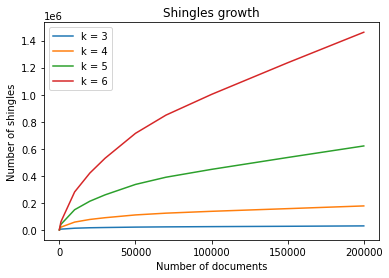

In [21]:
for k in [3, 4, 5, 6]:
    plt.plot(
        results[k]['docs'], 
        results[k]['shingles'],
        label=f'k = {k}'
    )
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of shingles')
plt.title('Shingles growth')
plt.legend(loc='best')
plt.savefig('img/shingles_growth.png', dpi=300)

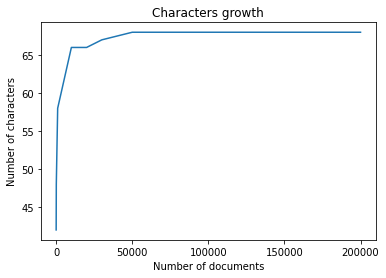

In [22]:
plt.plot(
    results[5]['docs'], 
    results[5]['characters']
)
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of characters')
plt.title('Characters growth')
plt.savefig('img/char_growth.png', dpi=300)

## Number of hash bits

In [13]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for n_bits in [12, 14, 16, 18, 19, 20, 22]:
        ckpt_path = f'checkpoints/k{k}_n_bits{n_bits}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=n_bits,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()

            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )

            sig_dict = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            start_time = timeit.default_timer()
            sig_dict = dict(model.get_similar_pairs())
            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, cm_fp = model.check_positives()
        cm_tp, cm_fp = dict(cm_tp), dict(cm_fp)
        cm_tn, cm_fn = model.check_negatives()
        cm_tn, cm_fn = dict(cm_tn), dict(cm_fn)
        evaluate_dict = evaluate_on_cm(
            sig_dict=sig_dict, 
            cm_tp_dict=cm_tp, 
            cm_fp_dict=cm_fp, 
            cm_tn_dict=cm_tn, 
            cm_fn_dict=cm_fn
        )

        ls.append(
            (
                n_bits, 
                len(sig_dict),
                evaluate_dict['recall'],
                evaluate_dict['precision'],
                evaluate_dict['f1-score'],
                evaluate_dict['mae'],
                str(datetime.timedelta(seconds=int(time_delta)))
            )
        )

        print(
            f'[k {k}, {n_bits} bits]:\n'
            f'\t{time_delta} seconds\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash Bits',  
            'Pairs No.',
            'Recall', 
            'Precision',
            'F1-Score',
            'MAE',
            'Time Delta'
        ]
    ).set_index('Hash Bits')

Loaded signature from row 4095


[k 3, 12 bits]:
	4.123127699999998 seconds

Loaded signature from row 16383


[k 3, 14 bits]:
	8.940224899999976 seconds

Loaded signature from row 65535


[k 3, 16 bits]:
	24.973088800000028 seconds

Loaded signature from row 262143


[k 3, 18 bits]:
	89.85631969999997 seconds

Loaded signature from row 524287


[k 3, 19 bits]:
	182.21257920000005 seconds

Loaded signature from row 1048575


[k 3, 20 bits]:
	353.45574039999997 seconds

Loaded signature from row 4194303


[k 3, 22 bits]:
	1405.0171513 seconds

Loaded signature from row 4095


[k 4, 12 bits]:
	3.600879000000077 seconds

Loaded signature from row 16383


[k 4, 14 bits]:
	7.544080599999688 seconds

Loaded signature from row 65535


[k 4, 16 bits]:
	24.67522089999966 seconds

Loaded signature from row 262143


[k 4, 18 bits]:
	92.27986789999977 seconds

Loaded signature from row 524287


[k 4, 19 bits]:
	186.1757603000001 seconds

Loaded signature from row 1048575


[k 4, 20 bits]:
	397.7329993000003 seconds

Loaded signature from row 4194303


[k 4, 22 bits]:
	1435.3596967000003 seconds

Loaded signature from row 4095


[k 5, 12 bits]:
	3.913744299999962 seconds

Loaded signature from row 16383


[k 5, 14 bits]:
	7.927894300000844 seconds

Loaded signature from row 65535


[k 5, 16 bits]:
	29.358010300000387 seconds

Loaded signature from row 262143


[k 5, 18 bits]:
	91.23157470000024 seconds

Loaded signature from row 524287


[k 5, 19 bits]:
	185.4467383000001 seconds

Loaded signature from row 1048575


[k 5, 20 bits]:
	351.8147024 seconds

Loaded signature from row 4194303


[k 5, 22 bits]:
	1422.619149099999 seconds



In [14]:
for k in [3, 4, 5]:
    print(results[k].round(3).to_latex()) 

\begin{tabular}{lrrrrrl}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE & Time Delta \\
Hash Bits &            &         &            &           &        &            \\
\midrule
12        &       2166 &   0.775 &      0.678 &     0.723 &  0.025 &    0:00:04 \\
14        &       2008 &   0.823 &      0.569 &     0.673 &  0.029 &    0:00:08 \\
16        &       1761 &   0.815 &      0.579 &     0.677 &  0.023 &    0:00:24 \\
18        &        995 &   0.525 &      0.634 &     0.574 &  0.023 &    0:01:29 \\
19        &       1564 &   0.730 &      0.559 &     0.633 &  0.030 &    0:03:02 \\
20        &       2108 &   0.866 &      0.492 &     0.628 &  0.033 &    0:05:53 \\
22        &       1125 &   0.594 &      0.632 &     0.612 &  0.023 &    0:23:25 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrl}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE & Time Delta \\
Hash Bits &            &         &            &           &        &            

## Threshold choice

In [15]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]:
        ckpt_path = f'checkpoints/k{k}_t{t}'

        model = LSHModel(
            k=k,
            threshold=t,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_dict = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()
            sig_dict = dict(model.get_similar_pairs())

        cm_tp, cm_fp = model.check_positives()
        cm_tp, cm_fp = dict(cm_tp), dict(cm_fp)
        cm_tn, cm_fn = model.check_negatives()
        cm_tn, cm_fn = dict(cm_tn), dict(cm_fn)
        evaluate_dict = evaluate_on_cm(
            sig_dict=sig_dict, 
            cm_tp_dict=cm_tp, 
            cm_fp_dict=cm_fp, 
            cm_tn_dict=cm_tn, 
            cm_fn_dict=cm_fn
        )

        ls.append(
            (
                t,
                len(sig_dict),
                evaluate_dict['recall'],
                evaluate_dict['precision'],
                evaluate_dict['f1-score'],
                evaluate_dict['mae'],
            )
        )

        print(
            f'[k {k}, {t} threshold]\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Threshold', 
            'Pairs No.',
            'Recall', 
            'Precision',
            'F1-Score',
            'MAE',
        ]
    ).set_index('Threshold')

Loaded signature from row 65535


[k 3, 0.05 threshold]

Loaded signature from row 65535


[k 3, 0.1 threshold]

Loaded signature from row 65535


[k 3, 0.15 threshold]

Loaded signature from row 65535


[k 3, 0.2 threshold]

Loaded signature from row 65535


[k 3, 0.25 threshold]

Loaded signature from row 65535


[k 3, 0.3 threshold]

Loaded signature from row 65535


[k 3, 0.5 threshold]

Loaded signature from row 65535


[k 4, 0.05 threshold]

Loaded signature from row 65535


[k 4, 0.1 threshold]

Loaded signature from row 65535


[k 4, 0.15 threshold]

Loaded signature from row 65535


[k 4, 0.2 threshold]

Loaded signature from row 65535


[k 4, 0.25 threshold]

Loaded signature from row 65535


[k 4, 0.3 threshold]

Loaded signature from row 65535


[k 4, 0.5 threshold]

Loaded signature from row 65535


[k 5, 0.05 threshold]

Loaded signature from row 65535


[k 5, 0.1 threshold]

Loaded signature from row 65535


[k 5, 0.15 threshold]

Loaded signature from row 65535


[k 5, 0.2 threshold]

Loaded signature from row 65535


[k 5, 0.25 threshold]

Loaded signature from row 65535


[k 5, 0.3 threshold]

Loaded signature from row 65535


[k 5, 0.5 threshold]



In [16]:
for k in [3, 4, 5]:
    print(results[k].round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE \\
Threshold &            &         &            &           &        \\
\midrule
0.05      &       4067 &   0.924 &      0.941 &     0.932 &  0.018 \\
0.10      &       1761 &   0.815 &      0.579 &     0.677 &  0.023 \\
0.15      &        242 &   0.582 &      0.236 &     0.335 &  0.037 \\
0.20      &         23 &   0.750 &      0.261 &     0.387 &  0.043 \\
0.25      &          4 &   1.000 &      0.750 &     0.857 &  0.032 \\
0.30      &          1 &   1.000 &      1.000 &     1.000 &  0.070 \\
0.50      &          1 &   1.000 &      1.000 &     1.000 &  0.070 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE \\
Threshold &            &         &            &           &        \\
\midrule
0.05      &       1819 &   0.791 &      0.650 &     0.714 &  0.016 \\
0.10      &        237 &   0.820 &      0.308 &     0.448 &  0.

## Number of hash functions

In [17]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for num_hashes in [20, 100, 200, 300, 500]:
        ckpt_path = f'checkpoints/k{k}_n_hash{num_hashes}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=num_hashes,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_dict = dict(model.get_similar_pairs())
            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            start_time = timeit.default_timer()
            sig_dict = dict(model.get_similar_pairs())
            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, cm_fp = model.check_positives()
        cm_tp, cm_fp = dict(cm_tp), dict(cm_fp)
        cm_tn, cm_fn = model.check_negatives()
        cm_tn, cm_fn = dict(cm_tn), dict(cm_fn)
        evaluate_dict = evaluate_on_cm(
            sig_dict=sig_dict, 
            cm_tp_dict=cm_tp, 
            cm_fp_dict=cm_fp, 
            cm_tn_dict=cm_tn, 
            cm_fn_dict=cm_fn
        )

        ls.append(
            (
                num_hashes,
                len(sig_dict),
                evaluate_dict['recall'],
                evaluate_dict['precision'],
                evaluate_dict['f1-score'],
                evaluate_dict['mae'],
                str(datetime.timedelta(seconds=int(time_delta)))
            )
        )

        print(
            f'[k {k}, {num_hashes} hashes]:\n'
            f'\t{time_delta} seconds\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash No.',
            'Pairs No.',
            'Recall', 
            'Precision',
            'F1-Score',
            'MAE',
            'Time Delta',
        ]
    ).set_index('Hash No.')

Loaded signature from row 65535


[k 3, 20 hashes]:
	19.395476699999563 seconds

Loaded signature from row 65535


[k 3, 100 hashes]:
	24.961890500000663 seconds

Loaded signature from row 65535


d:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


[k 3, 200 hashes]:
	31.503338699998494 seconds

Loaded signature from row 65535


[k 3, 300 hashes]:
	36.96477199999936 seconds

Loaded signature from row 65535


[k 3, 500 hashes]:
	45.66371319999962 seconds

Loaded signature from row 65535


[k 4, 20 hashes]:
	21.840279199999713 seconds

Loaded signature from row 65535


[k 4, 100 hashes]:
	25.556631299999935 seconds

Loaded signature from row 65535


[k 4, 200 hashes]:
	34.37156909999976 seconds

Loaded signature from row 65535


[k 4, 300 hashes]:
	40.5973410000006 seconds

Loaded signature from row 65535


[k 4, 500 hashes]:
	45.01985169999898 seconds

Loaded signature from row 65535


[k 5, 20 hashes]:
	19.631275800000367 seconds

Loaded signature from row 65535


[k 5, 100 hashes]:
	25.89462139999887 seconds

Loaded signature from row 65535


[k 5, 200 hashes]:
	29.35209919999943 seconds

Loaded signature from row 65535


[k 5, 300 hashes]:
	33.9280519999993 seconds

Loaded signature from row 65535


[k 5, 500 hashes]:
	43.95456439999907 seconds



In [18]:
for k in [3, 4, 5]:
    print(results[k].round(3).to_latex())

\begin{tabular}{lrrrrrl}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE & Time Delta \\
Hash No. &            &         &            &           &        &            \\
\midrule
20       &       1793 &   0.577 &      0.403 &     0.474 &  0.045 &    0:00:19 \\
100      &       1761 &   0.815 &      0.579 &     0.677 &  0.023 &    0:00:24 \\
200      &       1468 &   0.725 &      0.619 &     0.668 &  0.023 &    0:00:31 \\
300      &         74 &   0.046 &      0.770 &     0.086 &  0.019 &    0:00:36 \\
500      &          1 &   0.001 &      1.000 &     0.002 &  0.032 &    0:00:45 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrl}
\toprule
{} &  Pairs No. &  Recall &  Precision &  F1-Score &    MAE & Time Delta \\
Hash No. &            &         &            &           &        &            \\
\midrule
20       &        951 &   0.798 &      0.075 &     0.137 &  0.057 &    0:00:21 \\
100      &        237 &   0.820 &      0.308 &     0.448 &  0.031 &    0:00:25 

## 100,000 Tweets similarity

### Train LSH model

In [23]:
results = dict()
configs = [
    {'k': 3, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 16},
    {'k': 3, 'threshold': 0.8, 'num_hashes': 300, 'shingle_hash_bits': 16},
    {'k': 3, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 12},
    {'k': 3, 'threshold': 0.6, 'num_hashes': 100, 'shingle_hash_bits': 12},
    {'k': 4, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 18},
    {'k': 4, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 12},
    {'k': 5, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 16},
    {'k': 5, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 12}
]

for idx, config in enumerate(configs):
    ckpt_path = 'checkpoints/d100k/k{k}_t{threshold}_n_hashes{num_hashes}_n_bits{shingle_hash_bits}' \
        .format(**config)
    
    model = LSHModel(
        **config,
        track_shingles=True,
        checkpoint_path=ckpt_path
    )
    model = train_model(
        model=model, 
        data_path=DATA_PATH,
        num_docs=100000,
        verbose=True,
        filtering_pipeline=filtering_pipeline,
        preprocessing_pipeline=preprocessing_pipeline
    )

    similar_pairs = model.get_similar_pairs()
    sig_dict = dict(similar_pairs)
    cm_tp, cm_fp = model.check_positives()
    cm_tp, cm_fp = dict(cm_tp), dict(cm_fp)
    evaluate_dict = evaluate_on_cm(
        sig_dict=sig_dict, 
        cm_tp_dict=cm_tp, 
        cm_fp_dict=cm_fp
    )

    results[idx] = {
        **config,
        **evaluate_dict,
        'similar_pairs': similar_pairs,
        'num_total': len(similar_pairs),
        'tp': len(cm_tp),
        'fp': len(cm_fp)
    }

Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 65535


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 65535


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 4095


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 4095


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 262143


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                     

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 4095


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 65535


Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 4095


### Comparison with MPNet embeddings

In [24]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

In [25]:
mpnet_preprocessing = [
    remove_https,
    strip_accents,
    remove_non_ascii,
    replace_chars,
    normalize_white_space
]

In [26]:
ls = []

for idx in range(len(results)):
    model_results = results[idx]

    correlations = compare_similarity(
        model=mpnet,
        tokenizer=tokenizer,
        data_path=DATA_PATH,
        doc_sims=False,
        model_preprocessing=mpnet_preprocessing,
        filtering_pipeline=filtering_pipeline,
        similar_pairs=model_results['similar_pairs'],
        device=device
    )

    ls.append(
        (
            model_results['k'],
            model_results['threshold'], 
            model_results['num_hashes'], 
            model_results['shingle_hash_bits'],
            model_results['num_total'],
            model_results['precision'],
            model_results['mae'],
            correlations['tot_kendall'][0],
            correlations['tot_spearman'][0]
        )
    )

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                 

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                   

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


File block:   0%|          | 0/18 [00:00<?, ?it/s]                                 

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


In [27]:
res_df = pd.DataFrame(
    ls,
    columns=[
        'K',
        'T', 
        'Hash No.', 
        'Hash Bits',
        'Pairs No.',
        'Prec.',
        'MAE',
        'Kendall',
        'Spearman'
    ]
).set_index(['K', 'T', 'Hash No.', 'Hash Bits'])

In [28]:
res_df.round(3)

Pairs No.  Prec.    MAE  Kendall  Spearman
K T   Hash No. Hash Bits                                            
3 0.6 200      16            174941  0.956  0.023    0.229     0.323
  0.8 300      16             30917  0.903  0.015    0.076     0.109
  0.6 200      12            163221  0.967  0.020    0.230     0.319
      100      12            182562  0.940  0.029    0.219     0.304
4 0.6 200      18            112186  0.961  0.022    0.136     0.192
               12            108446  0.976  0.022    0.148     0.205
5 0.6 200      16             94191  0.900  0.027    0.143     0.202
               12             82153  0.977  0.022    0.115     0.161

In [29]:
print(res_df.round(3).to_latex())

\begin{tabular}{llllrrrrr}
\toprule
  &     &     &    &  Pairs No. &  Prec. &    MAE &  Kendall &  Spearman \\
K & T & Hash No. & Hash Bits &            &        &        &          &           \\
\midrule
3 & 0.6 & 200 & 16 &     174941 &  0.956 &  0.023 &    0.229 &     0.323 \\
  & 0.8 & 300 & 16 &      30917 &  0.903 &  0.015 &    0.076 &     0.109 \\
  & 0.6 & 200 & 12 &     163221 &  0.967 &  0.020 &    0.230 &     0.319 \\
  &     & 100 & 12 &     182562 &  0.940 &  0.029 &    0.219 &     0.304 \\
4 & 0.6 & 200 & 18 &     112186 &  0.961 &  0.022 &    0.136 &     0.192 \\
  &     &     & 12 &     108446 &  0.976 &  0.022 &    0.148 &     0.205 \\
5 & 0.6 & 200 & 16 &      94191 &  0.900 &  0.027 &    0.143 &     0.202 \\
  &     &     & 12 &      82153 &  0.977 &  0.022 &    0.115 &     0.161 \\
\bottomrule
\end{tabular}



In [30]:
[pair for pair in results[2]['similar_pairs'] if 15473 in pair[0]]

[((15473, 16182), 0.82), ((10886, 15473), 0.635), ((15473, 19499), 0.82)]

In [31]:
get_text(
    [15473, 16182, 10886, 19499],
    DATA_PATH, 
    filtering_pipeline=filtering_pipeline,
    add_info=False
)

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


[(10886,
  '@sputnikint @russiatoday @moscowtimes @moscowgov @emb_rus @russia Other 134,000 young #Russia conscript as soldiers to be sent by the old corrupt #Putin to die in #Ukraine, not for their homeland but only for  personal glory and enrichment of Putin and his gang. Is it worth it ? https://t.co/O4VH6KINOK'),
 (15473,
  '@russiatoday @russiaun @russianembassy @sputnikint @russiabeyond_it @russia @moscowtimes @russia Do the new 134,000 young men from #Russia conscripted by #Putin know that they go to die in #Ukraine not for their homeland but only for glory and enrichment of Putin and his gang? https://t.co/Ii2vebZOGf'),
 (16182,
  '@russiatoday @russiatodaynews @sputnikint @russiabeyond_it Do the new 134,000 young men from #Russia conscripted by #Putin know that they go to die in the mud of #Ukraine not for their homeland but only for glory and enrichment of the old, cancer patient #Putin and his gang? https://t.co/yDvPzJGlIq'),
 (19499,
  '@sputnikint @russiatoday @moscowgov @

In [32]:
[pair for pair in results[2]['similar_pairs'] if 9 in pair[0]]

[((9, 4175), 0.745), ((9, 1219), 0.81)]

In [33]:
get_text(
    [9, 4175, 1219],
    DATA_PATH, 
    filtering_pipeline=filtering_pipeline,
    add_info=False
)

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


[(9,
  '#Russia’s President Vladimir #Putin says he has signed a decree saying foreign buyers must pay in rubles for Russian gas from April 1, and contracts would be halted if these payments are not made.\n\nhttps://t.co/IUBuHMgw4n'),
 (1219,
  'Russian President Vladimir #Putin said on Thursday that he has signed a decree saying foreign buyers must pay in roubles for Russian gas from the first of #April and contracts would be halted if these payments were not made. https://t.co/BApCaIiaOo'),
 (4175,
  "Russian President #vladimir #Putin said that he had signed a decree saying foreign buyers must pay in roubles for #Russian gas from April 1, and contracts would be halted if these payments were not made. - Reuters\n\nDon't forgot to follow @letsponderit https://t.co/f5V7aaJ9IB")]

In [34]:
[pair for pair in results[2]['similar_pairs'] if 5790 in pair[0]]

[((5790, 5887), 0.905),
 ((5790, 5896), 0.875),
 ((5790, 7752), 0.805),
 ((5790, 13219), 0.92),
 ((5790, 5975), 0.92),
 ((5790, 8855), 0.695),
 ((5790, 7122), 0.84),
 ((5790, 7140), 0.87),
 ((5790, 9969), 0.85)]

In [35]:
get_text(
    [5790, 5887, 7752, 8855, 9969],
    DATA_PATH, 
    filtering_pipeline=filtering_pipeline,
    add_info=False
)

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


[(5790,
  'An oil depot is on fire in #Belgorod, #Russia. \n\n"The emergency services went to the place of fire, measures are being taken to eliminate it", said Gladkov, the governor of the region in his Telegram channel. https://t.co/ey7rC5ChSz'),
 (5887,
  'An oil depot is on fire in #Belgorod, #Russia. \n\n"The emergency services went to the place of fire, measures are being taken to eliminate it", said Gladkov, the governor of the region in his Telegram channel.#UkraineRussianWar https://t.co/pvsNWEvp1c'),
 (7752,
  'Horrible Video- An oil depot is on #fire in #Belgorod, #Russia. \n\n"The #emergency services went to the place of fire, measures are being taken to eliminate it", said #Gladkov, the governor of the region in his Telegram channel.\n#RussianWarCrimes #UkraineRussianWar https://t.co/WmqRo7LkaT'),
 (8855,
  'Horrible Video- An oil depot is on #fire in #Belgorod, #Russia. \nThe #emergency services went to the place of fire, measures are being taken to eliminate it, said #Gl

In [36]:
[pair for pair in results[2]['similar_pairs'] if 21773 in pair[0]]

[((11403, 21773), 0.63), ((21773, 21855), 0.635), ((11461, 21773), 0.625)]

In [37]:
get_text(
    [11403, 21773, 21855, 21773],
    DATA_PATH, 
    filtering_pipeline=filtering_pipeline,
    add_info=False
)

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


[(11403,
  'Excuses, excuses? Why some companies won’t stop trading in Russia \n\nhttps://t.co/3wGHIzKbge #HolocaustMemorialDay #MLK #GrenfellTower #BidenHarris #BlackLivesMatter  #OprahMeghanHarry #ReparationsNow #Zelensky #Ukraine #Kyiv #karkhiv #Kherson #Odesa #Lviv #Mariupol #Lutsk'),
 (21773,
  'If Putin is to be tried for war crimes, of course he can’t remain in power https://t.co/CGmEEQlRu7 #HolocaustMemorialDay #MLK #GrenfellTower #BidenHarris #BlackLivesMatter  #OprahMeghanHarry #ReparationsNow #Zelensky #Ukraine #Kyiv #karkhiv #Odesa #Lviv #Mariupol #Lutsk #Dnipro'),
 (21855,
  "Putin's white privilege\n\nProsecuting war crimes demands outrage, will and action \n\nhttps://t.co/3vbAFtqjY0 #HolocaustMemorialDay #MLK #GrenfellTower #BidenHarris #BlackLivesMatter  #OprahMeghanHarry #ReparationsNow #Zelensky #Ukraine #Kyiv #karkhiv #Kherson #Odesa #Lviv #Mariupol")]

### Comparison test

In [38]:
sentences = [
    'I went to the bank to withdraw money and compensate the plaintiff for their losses.',
    'The Russians are withdrawing from the banks of the Dnipro River after suffering heavy losses.',
    'After the judgement, I had to use my debit card and pay the suer for the damages.'
]

#### Jaccard similarity with shingles

In [39]:
docs_dict = dict()
k = 3

for i, sentence in enumerate(sentences):

    shingles = set()

    for f in [
        str.lower,
        strip_punctuation,
        get_lemmatizer(nlp),
        normalize_white_space
    ]:
        sentence = f(sentence)

    for j in range(len(sentence[:-k+1])):
        shingle = sentence[j:j+k]
        shingles.add(shingle)

    docs_dict[i] = shingles

for i, _ in enumerate(sentences):
    for j in range(i+1, len(sentences)):
        sim = jaccard_similarity(
            docs_dict[i], docs_dict[j]
        )
        print(((i,j), round(sim, 3)))

((0, 1), 0.185)
((0, 2), 0.0)
((1, 2), 0.023)


#### MPNet

In [40]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

encoded_input = tokenizer(
    sentences, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
).to(device)

with torch.no_grad():
    model_output = mpnet(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

for i, _ in enumerate(sentences):
    for j in range(i+1, len(sentences)):
        sim = torch_cosine_similarity(
            embeddings[i],
            embeddings[j],
        )
        print(((i,j), sim.cpu().numpy().round(3)))

((0, 1), 0.192)
((0, 2), 0.648)
((1, 2), 0.131)
